# 0.0. IMPORTS

In [1]:
import pandas as pd
import inflection
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import Image

import datetime

from scipy import stats

In [83]:
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder

## 0.1. Helper Functions

In [2]:
def cramer_v(x, y):
    cm = pd.crosstab(x, y).as_matrix()
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = stats.chi2_contingency(cm)[0]
    chi2_corrected = chi2 - ((k - 1)*(r - 1))/(n - 1)
    k_corrected = k - ((k - 1)**2)/(n - 1)
    r_corrected = r - ((r - 1)**2)/(n - 1)
    
    return np.sqrt((chi2_corrected/n) / (min(k_corrected - 1, r_corrected - 1)))

## 0.2. Loading Data

In [3]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('data/store.csv', low_memory=False)

# merge dataframes
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store' )

In [4]:
df_raw.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
188892,458,4,2015-02-12,5242,560,1,0,0,0,c,a,3390.0,NaN,NaN,0,NaN,NaN,NaN


# 1.0. DESCRICAO DOS DADOS

In [5]:
# Original dataframe copy
df1 = df_raw.copy()

## 1.1. Rename columns

In [6]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [7]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

# Changing write pattern to snakecase

snakecase = lambda x: inflection.underscore( x )

cols_new = list( map( snakecase, cols_old ) )

# Renaming
df1.columns = cols_new

In [8]:
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 1.2. Data Dimension

In [9]:
print( 'Number of rows: {}'.format(df1.shape[0]))
print( 'Number of rows: {}'.format(df1.shape[1]))

Number of rows: 1017209
Number of rows: 18


## 1.3. Data Types

In [10]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [11]:
df1['date'] = pd.to_datetime(df1['date'])

df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Check NA

In [12]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Fillout NA

In [13]:
# First, we must analyze what every variable and data with NA values

# competition_distance
## Assumption: if it is NA, maybe it is because the store doesnt have an near competitor
## What has been done: CONSIDER AN EXTREME DISTANT RANGE FROM NEAR COMPETITOR

df1['competition_distance'].max()
df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 100000 if math.isnan(x) else x )

# competition_open_since_month
## Assumption: there are two main reasons that this data is NA: (i) the store doesnt have a near competitor or
## (ii) the store has an near competitor, but it the opening data is unknown, either it is older than the store or data is unavailable
## What has been done: CONSIDER THE SAME MONTH THAT THE STORE HAS BEEN OPEN (because it maybe older than the store)

# Error: EDIT Solved
df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)
#Alternative: 
#df1.competition_open_since_month.fillna(df1.date.dt.month, inplace=True)

# competition_open_since_year
## Same ideia from variable above

#Error: EDIT: Solved
df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)
#Alternative: 
#df1.competition_open_since_year.fillna(df1.date.dt.month, inplace=True)



# promo2
## Doesnt have any NA

# promo2_since_week
## Assumption: it is possible that the NA values are due to lack of participation/extension of any promotions.
## What I think should have been done: ALL NA VALUES ARE CONSIDERED "0", AS THE STORE IS NOT EXTENDING PROMOTIONS
## What has actually been done: CONSIDER THE SAME VALUE AS THE DATE
df1['promo2_since_week'] = df1.apply( lambda x: x['date'].month if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)


# promo2_since_year
## Same logic as above
df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)


# promo_interval
## The problem here is that, it is hard to understand the way it has been inserted.
## What has been done: (i) Analyze the interval of the promo; (ii) Check if sale month is in promo_interval
## if it is, (iii) apply value 1 to new column is_promo, else 0.
## This way, it will be easy to check if sale is inside a promotion interval.

month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec', }

df1['promo_interval'].fillna(0, inplace=True)
df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1 )

df1.isna().sum()


store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

In [14]:
df1.sample(5).T

,997103,358184,294078,285742,639486
store,1079,311,796,888,262
day_of_week,6,6,5,7,4
date,2013-01-19 00:00:00,2014-08-23 00:00:00,2014-10-31 00:00:00,2014-11-09 00:00:00,2013-12-05 00:00:00
sales,6060,5012,7763,0,24264
customers,484,561,827,0,3375
open,1,1,1,0,1
promo,0,0,0,0,1
state_holiday,0,0,0,0,0
school_holiday,0,1,0,0,0
store_type,a,a,a,d,b


## 1.6. Change Types

In [15]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [16]:
# Competion and promos since are portrayed as float types, while it should be int type.

df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7. Descriptive Statistical

In [17]:
num_attributes = df1.select_dtypes( include=['int64','float64'])
cat_attributes = df1.select_dtypes( exclude=['int64','float64', 'datetime64[ns]'])

num_attributes.sample(5)

,store,day_of_week,sales,customers,open,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo
637504,510,6,6220,632,1,0,0,8260.0,12,2013,0,12,2013,0
292440,1069,7,0,0,0,0,0,18050.0,11,2014,1,14,2011,0
21440,256,7,0,0,0,0,0,80.0,9,2005,1,10,2014,0
146720,656,7,0,0,0,0,0,410.0,4,2009,1,13,2010,0
449803,129,6,8066,1165,1,0,0,2460.0,5,2014,1,14,2011,0


### 1.7.1. Numerical Attributes

In [18]:
# Central tendency - mean, median

ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion - std, min, max, range, skew, kurtosis

d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# Concatenate

n = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
                  
n.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

n

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,100000.0,99980.0,5675.712376,2330.0,9085.159292,4.637208,35.287543
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


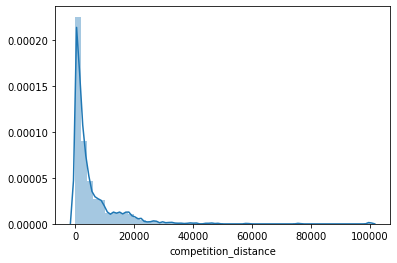

In [19]:
sns.distplot( df1['competition_distance'] )

### 1.7.2. Categorical Attributes

In [20]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

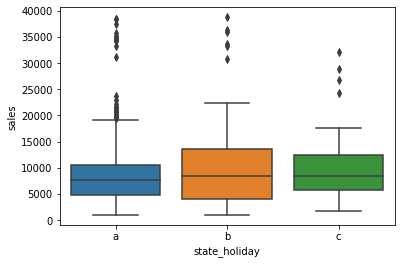

In [21]:
filter1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]
sns.boxplot(x='state_holiday', y='sales', data=filter1)

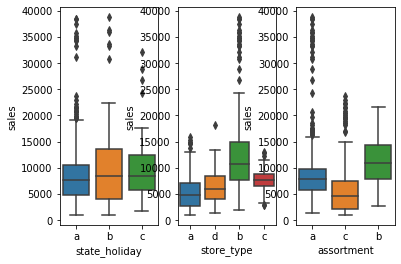

In [22]:
plt.subplot(1,3,1)
sns.boxplot(x='state_holiday', y='sales', data=filter1)

plt.subplot(1,3,2)
sns.boxplot(x='store_type', y='sales', data=filter1)

plt.subplot(1,3,3)
sns.boxplot(x='assortment', y='sales', data=filter1)

# 2.0. FEATURE ENGINEERING

In [23]:
df2 = df1.copy()

df2.sample(5)

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo
851857,783,3,2013-05-29,6576,666,1,1,0,0,d,c,15490.0,5,2013,0,5,2013,0,May,0
720952,333,1,2013-09-23,11427,1425,1,1,0,0,a,c,3720.0,2,2010,0,9,2013,0,Sep,0
50902,728,2,2015-06-16,5346,426,1,1,0,0,d,a,13990.0,6,2015,1,14,2011,"Jan,Apr,Jul,Oct",Jun,0
121360,941,2,2015-04-14,6971,672,1,1,0,0,a,a,1200.0,12,2011,1,31,2013,"Jan,Apr,Jul,Oct",Apr,1
665001,132,2,2013-11-12,4836,491,1,0,0,0,d,c,1040.0,11,2013,1,27,2012,"Jan,Apr,Jul,Oct",Nov,0


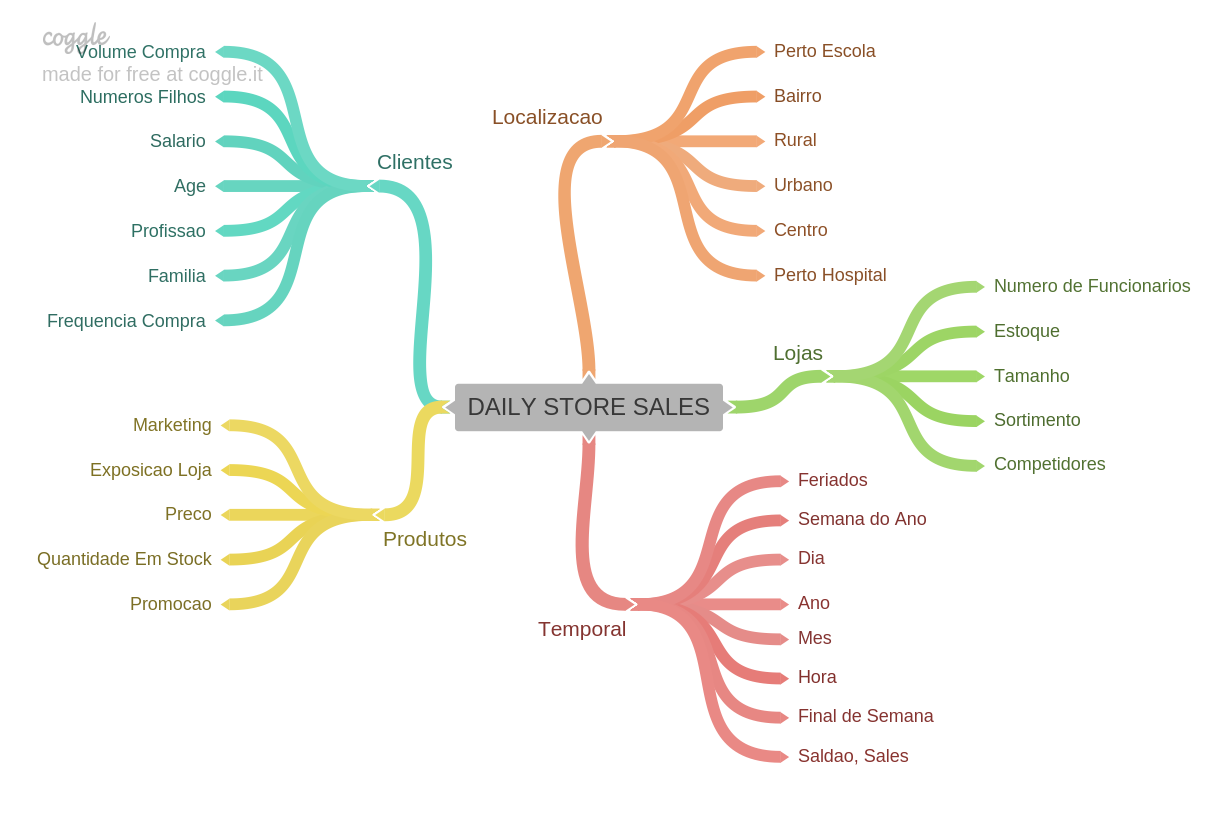

In [24]:
Image('img/MindMapHypothesis.png')

## 2.1. Hypothesis mental map

### 2.1.1. Stores Hypothesis

**1.** Stores with more employees **should** have more sales

**2.** Stores with more product stock **should** have more sales

**3.** Smaller stores **should** have less sales

**4.** Bigger stores **should** have more sales

**5.** Stores with more product options **should** have more sales

### 2.1.2. Product Hypothesis

**1.** Stores with more marketing investment **should** have more sales

**2.** Stores that exposes more the products **should** sell more those products

**3.** Stores with smaller product prices **should** have more sales of those products

**4.** Stores with smaller product prices for the longest possible time **should** have more sales

### 2.1.3. Time Hypothesis

**1.** Stores with more holidays **should** have less sales

**2.** Stores that opens at the first 6 months **should** have more sales

**3.** Stores that opens at the weekends **should** have more sales

## 2.2. Hypothesis priorization

The hypothesis that should have prioritized are the ones with the data available at the start of the proccess

**1.** Stores with more product options **should** have more sales

**2.** Stores with closer competitors **should** have less sales

**3.** Stores with competitors open for the longest time **should** have more sales


**4.** Stores with more active promotions **should** have more sales

**5.** Stores with more promotion days **should** have more sales

**6.** Stores with consecutive promotions **should** have more sales


**7.** Stores open at Xmas **should** have more sales

**8.** Stores sales **should** grow through the years

**9.** Stores **should** sell more at the second half of the year

**10.** Stores **should** sell more after the tenth day of each month

**11.** Stores **should** sell less at the weekends

**12.** Stores **should** sell less at school holydays

## 2.3 Feature Engineering

In [25]:
#year
df2['year'] = df2['date'].dt.year

#month
df2['month'] = df2['date'].dt.month

#day
df2['day'] = df2['date'].dt.day

#weekofyear
df2['week_of_year'] = df2['date'].dt.weekofyear

#year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

#competitionsince
df2['competition_since'] = df2.apply( lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1 )
df2['competition_time_month'] = ((df2['date'] - df2['competition_since']) / 30).apply(lambda x: x.days).astype(int)

#promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7) )
df2['promo_time_week'] = ((df2['date'] - df2['promo_since']) / 7).apply(lambda x: x.days ).astype(int)

#assortment
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x=='a' else 'extra' if x=='b' else 'extended')

#state holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x=='a' else 'easter_holiday' if x=='b' else 'christmas' if x=='c' else 'regular_day')

In [26]:
df2.sample(5).T

,148895,845841,350811,723672,248285
store,601,342,433,823,824
day_of_week,5,1,7,6,5
date,2015-03-20 00:00:00,2013-06-03 00:00:00,2014-08-31 00:00:00,2013-09-21 00:00:00,2014-12-19 00:00:00
sales,5330,13490,2214,3653,11404
customers,415,984,256,358,1299
open,1,1,1,1,1
promo,1,1,0,0,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,0,0,0,0,0
store_type,d,d,a,a,a


# 3.0. VARIABLE FILTERING

In [27]:
df3 = df2.copy()

## 3.1. Line Filtering

In [28]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2. Column FIltering

In [29]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']

df3 = df3.drop(cols_drop, axis = 1)

# 4.0. EXPLORATORY DATA ANALYSIS

In [30]:
df4 = df3.copy()

## 4.1. Univariate Analysis

### 4.1.1. Response Variable

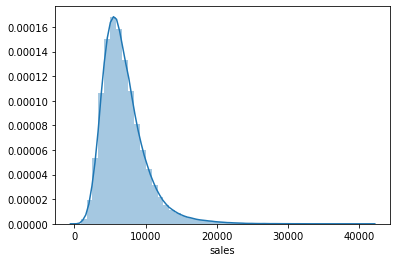

In [31]:
sns.distplot(df4['sales'])

# The more the graph seems like a bell curve, the better.
# It is because some models and algorithms are based on normal shape curve
# Applying functions such as log makes the graph looks more like the bell.

### 4.1.2. Numerical Variable

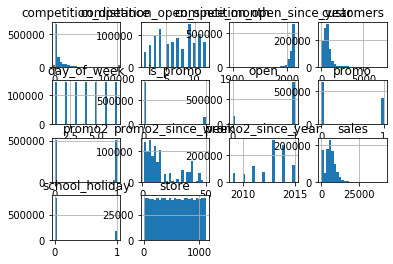

In [32]:
num_attributes.hist(bins=25)

plt.show()

### 4.1.3 Categorical Variable

In [33]:
cat_attributes.sample(5)

,state_holiday,store_type,assortment,promo_interval,month_map
162249,0,a,a,"Jan,Apr,Jul,Oct",Mar
712762,0,a,c,0,Oct
707214,0,a,a,"Jan,Apr,Jul,Oct",Oct
764982,0,d,c,0,Aug
173133,0,d,a,"Feb,May,Aug,Nov",Fev


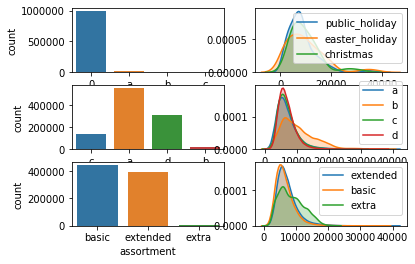

In [34]:


# State holiday
plt.subplot(3, 2, 1)
#a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(cat_attributes['state_holiday'])

plt.subplot(3, 2, 2)
sns.kdeplot( df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True)
sns.kdeplot( df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True)
sns.kdeplot( df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True)





# Store type
plt.subplot(3, 2, 3)
sns.countplot(cat_attributes['store_type'])

plt.subplot(3, 2, 4)
sns.kdeplot( df4[df4['store_type'] == 'a']['sales'], label='a', shade=True)
sns.kdeplot( df4[df4['store_type'] == 'b']['sales'], label='b', shade=True)
sns.kdeplot( df4[df4['store_type'] == 'c']['sales'], label='c', shade=True)
sns.kdeplot( df4[df4['store_type'] == 'd']['sales'], label='d', shade=True)

# Assortment
plt.subplot(3, 2, 5)
sns.countplot(df4['assortment'])

plt.subplot(3, 2, 6)
sns.kdeplot( df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True)
sns.kdeplot( df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True)
sns.kdeplot( df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True)





## 4.2. Bivariate Analysis

### Hypothesis **1.** Stores with more product options **should** have more sales

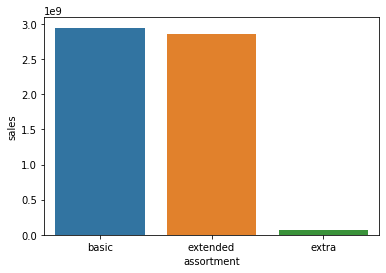

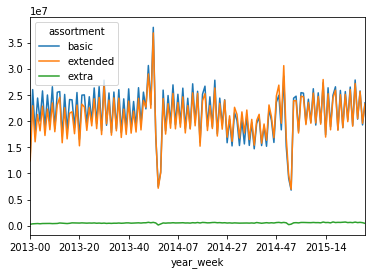

In [35]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment', y='sales', data= aux1);

aux2 = df4[['year_week','assortment', 'sales']].groupby(['year_week','assortment']).sum().reset_index()
aux2.pivot(index='year_week', columns='assortment', values='sales').plot()
#sns.barplot(x='assortment', y='sales', data= aux2);

**False** Results shows that the basic assortment store type, sells **more** than a store with more assortment

### Hypothesis **2.** Stores with closer competitors **should** have less sales

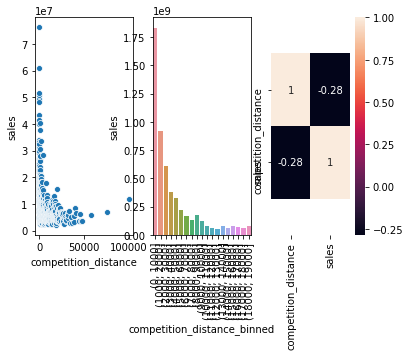

In [36]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

plt.subplot (1, 3, 1)
bins = list(np.arange(0, 20000, 1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
#sns.barplot(x='competition_distance_binned', y='sales', data= aux1);
sns.scatterplot(x='competition_distance', y='sales', data=aux1)

plt.subplot(1, 3, 2)
aux2 = aux1[['competition_distance_binned','sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x='competition_distance_binned', y='sales', data= aux2);
plt.xticks(rotation=90)

plt.subplot(1, 3, 3)
x = sns.heatmap(aux1.corr(method='pearson'), annot=True)
bottom, top = x.get_ylim()
x.set_ylim(bottom+0.5, top-0.5);

**False** Stores with closer competitors actually sells **more** than stores with distant competitors

### Hypothesis **3.** Stores with competitors open for the longest time **should** have more sales

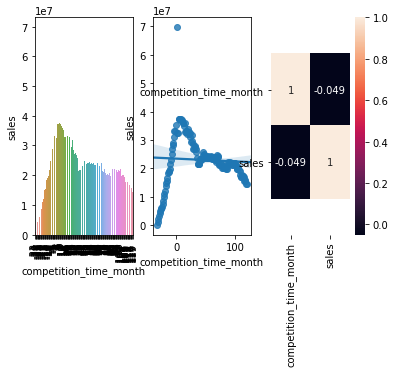

In [37]:
plt.subplot(1, 3, 1)
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux4 = aux1[(aux1['competition_time_month'] < 120 ) & (aux1['competition_time_month'] != 0) ]
sns.barplot(x='competition_time_month', y='sales', data=aux4)
plt.xticks(rotation=90);

plt.subplot(1, 3, 2)
sns.regplot(x='competition_time_month', y='sales', data=aux4)

plt.subplot(1, 3, 3)
x = sns.heatmap(aux4.corr(method='pearson'), annot=True)
bottom, top = x.get_ylim()
x.set_ylim(bottom+0.5, top-0.5);

**False** stores with longer competition sells **less**. However, the behavior of sales is different before competition starts and after it starts.

## 4.3. Multivariate Analysis

### 4.3.1. Numerical Attributes

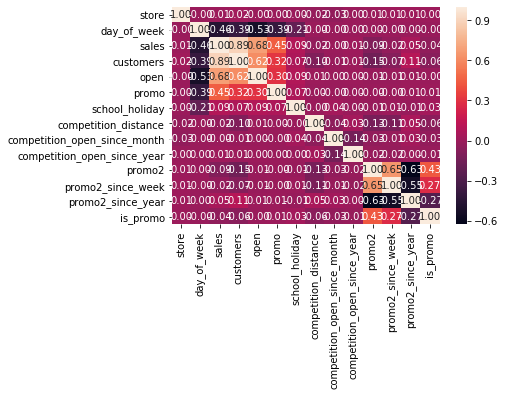

In [38]:
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True, fmt='.2f')

### 4.3.2. Categorical Attributes

In [39]:
from scipy import stats

categorical = df4.select_dtypes(include='object')
categorical.head()

,state_holiday,store_type,assortment,year_week
0,regular_day,c,basic,2015-30
1,regular_day,a,basic,2015-30
2,regular_day,a,basic,2015-30
3,regular_day,c,extended,2015-30
4,regular_day,a,basic,2015-30


In [40]:
cm = pd.crosstab(categorical['state_holiday'], categorical['store_type']).as_matrix()



<ipython-input-40-c0215fa5e443>:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  cm = pd.crosstab(categorical['state_holiday'], categorical['store_type']).as_matrix()


In [41]:
a1 = cramer_v(categorical['state_holiday'], categorical['state_holiday'])
a2 = cramer_v(categorical['state_holiday'], categorical['store_type'])
a3 = cramer_v(categorical['state_holiday'], categorical['assortment'])

a4 = cramer_v(categorical['store_type'], categorical['state_holiday'])
a5 = cramer_v(categorical['store_type'], categorical['store_type'])
a6 = cramer_v(categorical['store_type'], categorical['assortment'])

a7 = cramer_v(categorical['assortment'], categorical['state_holiday'])
a8 = cramer_v(categorical['assortment'], categorical['store_type'])
a9 = cramer_v(categorical['assortment'], categorical['assortment'])

d = pd.DataFrame({'state_holiday': [a1, a2, a3],
              'store_type': [a4, a5, a6],
              'assortment': [a7, a8, a9] })

<ipython-input-2-cddd5d3c621c>:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  cm = pd.crosstab(x, y).as_matrix()


In [42]:
d = d.set_index(d.columns)
d.head()

,state_holiday,store_type,assortment
state_holiday,1.000002,0.071065,0.067546
store_type,0.071065,1.000002,0.538457
assortment,0.067546,0.538457,1.000001


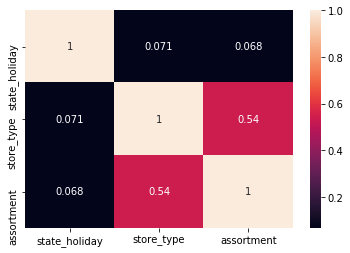

In [43]:
sns.heatmap(d, annot=True)

# 5.0. DATA PREPARATION

In [89]:
df5 = df4.copy()

## 5.1. Data normalization

## 5.2. Data rescaling

In [90]:
a = df5.select_dtypes(include=['int64','float64'])

In [91]:
a.head()

,store,day_of_week,sales,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,competition_time_month,promo_time_week
0,1,5,5263,1,1,1270.0,9,2008,0,7,2015,0,2015,7,31,31,84,24
1,2,5,6064,1,1,570.0,11,2007,1,13,2010,1,2015,7,31,31,94,279
2,3,5,8314,1,1,14130.0,12,2006,1,14,2011,1,2015,7,31,31,105,226
3,4,5,13995,1,1,620.0,9,2009,0,7,2015,0,2015,7,31,31,71,24
4,5,5,4822,1,1,29910.0,4,2015,0,7,2015,0,2015,7,31,31,4,24


In [92]:
# Before choosing which rescale method will be used, we must know which variables have outliers.
#sns.boxplot(df5['competition_distance'])


# competition distance
rs = RobustScaler()
df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values )

# competition time month
mms = MinMaxScaler()
df5['competition_time_month'] = mms.fit_transform( df5[['competition_time_month']].values )

# year
df5['year'] = mms.fit_transform( df5[['year']].values )

# promo time week
df5['promo_time_week'] = mms.fit_transform( df5[['promo_time_week']].values )

#sns.distplot(df5['competition_distance'])

## 5.3. Data transformation

### 5.3.1. Categorical transformation

In [93]:
#df5.select_dtypes('object')

# state holiday - One hot encoding
df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'])
df5.head()


,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,...,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day
0,1,5,2015-07-31,5263,1,1,c,basic,-0.170968,9,...,31,2015-30,2008-09-01,0.080612,2015-02-09,0.341686,0,0,0,1
1,2,5,2015-07-31,6064,1,1,a,basic,-0.283871,11,...,31,2015-30,2007-11-01,0.087561,2010-03-22,0.922551,0,0,0,1
2,3,5,2015-07-31,8314,1,1,a,basic,1.903226,12,...,31,2015-30,2006-12-01,0.095205,2011-03-28,0.801822,0,0,0,1
3,4,5,2015-07-31,13995,1,1,c,extended,-0.275806,9,...,31,2015-30,2009-09-01,0.071577,2015-02-09,0.341686,0,0,0,1
4,5,5,2015-07-31,4822,1,1,a,basic,4.448387,4,...,31,2015-30,2015-04-01,0.025017,2015-02-09,0.341686,0,0,0,1


In [94]:
# store type - Label Encoder
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])

# assortment - Ordinal Encoder
assortment_dict = {'basic':1, 'extra':2, 'extended':3}
df5['assortment'] = df5['assortment'].map(assortment_dict)
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,...,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day
0,1,5,2015-07-31,5263,1,1,2,1,-0.170968,9,...,31,2015-30,2008-09-01,0.080612,2015-02-09,0.341686,0,0,0,1
1,2,5,2015-07-31,6064,1,1,0,1,-0.283871,11,...,31,2015-30,2007-11-01,0.087561,2010-03-22,0.922551,0,0,0,1
2,3,5,2015-07-31,8314,1,1,0,1,1.903226,12,...,31,2015-30,2006-12-01,0.095205,2011-03-28,0.801822,0,0,0,1
3,4,5,2015-07-31,13995,1,1,2,3,-0.275806,9,...,31,2015-30,2009-09-01,0.071577,2015-02-09,0.341686,0,0,0,1
4,5,5,2015-07-31,4822,1,1,0,1,4.448387,4,...,31,2015-30,2015-04-01,0.025017,2015-02-09,0.341686,0,0,0,1


In [95]:

# year week

In [ ]:
# day of week
# month
# day
# week of year